# Face Generation

In this project, you'll define and train a Generative Adverserial network of your own creation on a dataset of faces. Your goal is to get a generator network to generate *new* images of faces that look as realistic as possible!

The project will be broken down into a series of tasks from **defining new architectures training adversarial networks**. At the end of the notebook, you'll be able to visualize the results of your trained Generator to see how it performs; your generated samples should look like fairly realistic faces with small amounts of noise.

### Get the Data

You'll be using the [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) to train your adversarial networks.

This dataset has higher resolution images than datasets you have previously worked with (like MNIST or SVHN) you've been working with, and so, you should prepare to define deeper networks and train them for a longer time to get good results. It is suggested that you utilize a GPU for training.

### Pre-processed Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. Some sample data is show below.

<img src='assets/processed_face_data.png' width=60% />

> If you are working locally, you can download this data [by clicking here](https://s3.amazonaws.com/video.udacity-data.com/topher/2018/November/5be7eb6f_processed-celeba-small/processed-celeba-small.zip)

This is a zip file that you'll need to extract in the home directory of this notebook for further loading and processing. After extracting the data, you should be left with a directory of data `processed-celeba-small/`.

In [1]:
import sys
print(sys.version)


3.7.6 | packaged by conda-forge | (default, Jan  7 2020, 22:33:48) 
[GCC 7.3.0]


In [2]:
!conda info



     active environment : None
       user config file : /root/.condarc
 populated config files : /opt/conda/.condarc
          conda version : 4.8.2
    conda-build version : not installed
         python version : 3.7.6.final.0
       virtual packages : __cuda=11.4
                          __glibc=2.27
       base environment : /opt/conda  (read only)
           channel URLs : https://conda.anaconda.org/conda-forge/linux-64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/linux-64
                          https://repo.anaconda.com/pkgs/main/noarch
                          https://repo.anaconda.com/pkgs/r/linux-64
                          https://repo.anaconda.com/pkgs/r/noarch
          package cache : /opt/conda/pkgs
                          /root/.conda/pkgs
       envs directories : /root/.conda/envs
                          /opt/conda/envs
               platform : linux-64
             us

In [3]:
!conda env list

# conda environments:
#
base                  *  /opt/conda



In [4]:
import torch

# Check if CUDA is available
cuda_available = torch.cuda.is_available()

# Print the result
print(f"CUDA available: {cuda_available}")

# Print the CUDA version if available
if cuda_available:
    print(f"CUDA version: {torch.version.cuda}")
    print(f"Number of CUDA devices: {torch.cuda.device_count()}")
    print(f"Current CUDA device: {torch.cuda.current_device()}")
    print(f"CUDA device name: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("Torch not compiled with CUDA enabled or no CUDA devices available.")


CUDA available: True
CUDA version: 10.2
Number of CUDA devices: 1
Current CUDA device: 0
CUDA device name: Tesla T4


In [5]:
from glob import glob
from typing import Tuple, Callable, Dict

from torch import nn, Tensor
from torch.nn import Module, ConvTranspose2d, BatchNorm2d, ReLU, Tanh, Sequential

from typing import Tuple, Callable
from torchvision.transforms import Compose, ToTensor, Resize, Normalize

import matplotlib.pyplot as plt
import numpy as np
import torch
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, ToTensor

import tests

In [6]:
data_dir = 'processed_celeba_small/celeba/'

## Data pipeline

The [CelebA](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations. Since you're going to be generating faces, you won't need the annotations, you'll only need the images. Note that these are color images with [3 color channels (RGB)](https://en.wikipedia.org/wiki/Channel_(digital_image)#RGB_Images) each.

### Pre-process and Load the Data

Since the project's main focus is on building the GANs, we've done *some* of the pre-processing for you. Each of the CelebA images has been cropped to remove parts of the image that don't include a face, then resized down to 64x64x3 NumPy images. This *pre-processed* dataset is a smaller subset of the very large CelebA dataset and contains roughly 30,000 images. 

Your first task consists in building the dataloader. To do so, you need to do the following:
* implement the get_transforms function
* create a custom Dataset class that reads the CelebA data

### Exercise: implement the get_transforms function

The `get_transforms` function should output a [`torchvision.transforms.Compose`](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html#torchvision.transforms.Compose) of different transformations. You have two constraints:
* the function takes a tuple of size as input and should **resize the images** to the input size
* the output images should have values **ranging from -1 to 1**

In [7]:
def get_transforms(size: Tuple[int, int]) -> Callable:
    """ Transforms to apply to the image."""
    transforms = [Resize(size), ToTensor()]
    return Compose(transforms)


### Exercise: implement the DatasetDirectory class


The `DatasetDirectory` class is a torch Dataset that reads from the above data directory. The `__getitem__` method should output a transformed tensor and the `__len__` method should output the number of files in our dataset. You can look at [this custom dataset](https://pytorch.org/tutorials/beginner/basics/data_tutorial.html#creating-a-custom-dataset-for-your-files) for ideas. 

In [8]:
import os
from PIL import Image
from torch.utils.data import Dataset
from typing import Callable

class DatasetDirectory(Dataset):
    def __init__(self, directory, transforms=None, extension='.jpg'):
        self.directory = directory
        self.transforms = transforms
        self.extension = extension
        self.images = [file for file in os.listdir(directory) if file.endswith(extension)]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.directory, self.images[index])
        image = Image.open(img_path)
        if self.transforms:
            image = self.transforms(image)
        return image
    

In [9]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your dataset implementation
dataset = DatasetDirectory(data_dir, get_transforms((64, 64)))
tests.check_dataset_outputs(dataset)

Congrats, your dataset implementation passed all the tests


The functions below will help you visualize images from the dataset.

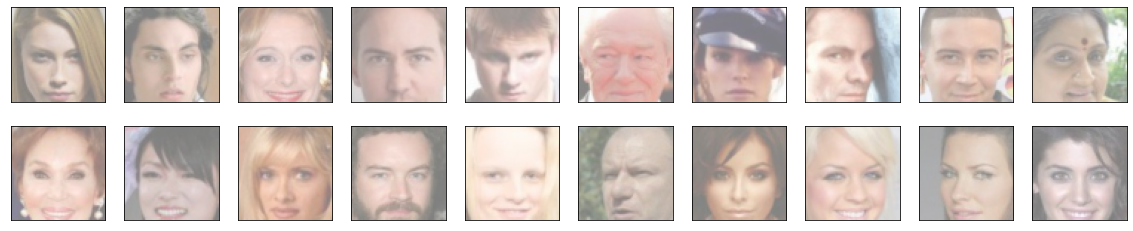

In [10]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def denormalize(images):
    """Transform images from [-1.0, 1.0] to [0, 255] and cast them to uint8."""
    return ((images + 1.) / 2. * 255).astype(np.uint8)

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))
plot_size=20
for idx in np.arange(plot_size):
    ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
    img = dataset[idx].numpy()
    img = np.transpose(img, (1, 2, 0))
    img = denormalize(img)
    ax.imshow(img)

## Model implementation

As you know, a GAN is comprised of two adversarial networks, a discriminator and a generator. Now that we have a working data pipeline, we need to implement the discriminator and the generator. 

Feel free to implement any additional class or function.

### Exercise: Create the discriminator

The discriminator's job is to score real and fake images. You have two constraints here:
* the discriminator takes as input a **batch of 64x64x3 images**
* the output should be a single value (=score)

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips
* To scale down from the input image, you can either use `Conv2d` layers with the correct hyperparameters or Pooling layers.
* If you plan on using gradient penalty, do not use Batch Normalization layers in the discriminator.

In [11]:
import torch
from torch.nn import Module, Conv2d, BatchNorm2d, LeakyReLU, Sigmoid, Sequential

In [12]:
import torch
import torch.nn as nn

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Added Sigmoid activation function
        )

    def forward(self, x):
        return self.main(x).view(-1, 1, 1, 1)


In [13]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to check your discriminator implementation
discriminator = Discriminator()
tests.check_discriminator(discriminator)

Congrats, your discriminator implementation passed all the tests


### Exercise: create the generator

The generator's job creates the "fake images" and learns the dataset distribution. You have three constraints here:
* the generator takes as input a vector of dimension `[batch_size, latent_dimension, 1, 1]`
* the generator must outputs **64x64x3 images**

Feel free to get inspiration from the different architectures we talked about in the course, such as DCGAN, WGAN-GP or DRAGAN.

#### Some tips:
* to scale up from the latent vector input, you can use `ConvTranspose2d` layers
* as often with Gan, **Batch Normalization** helps with training

In [14]:
import torch.nn as nn
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, z_size, conv_dim=64):
        super(Generator, self).__init__()
        self.conv_dim = conv_dim
        self.main = nn.Sequential(
            nn.ConvTranspose2d(z_size, conv_dim * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(conv_dim * 8),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim * 8, conv_dim * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 4),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim * 4, conv_dim * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim * 2),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim * 2, conv_dim, 4, 2, 1, bias=False),
            nn.BatchNorm2d(conv_dim),
            nn.ReLU(True),
            nn.ConvTranspose2d(conv_dim, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)



In [15]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
# run this cell to verify your generator implementation
latent_dim = 128
generator = Generator(latent_dim)
tests.check_generator(generator, latent_dim)

Congrats, your generator implementation passed all the tests


## Optimizer

In the following section, we create the optimizers for the generator and discriminator. You may want to experiment with different optimizers, learning rates and other hyperparameters as they tend to impact the output quality.

### Exercise: implement the optimizers

In [16]:
import torch.optim as optim

def create_optimizers(generator, discriminator):
    d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    return g_optimizer, d_optimizer


## Losses implementation

In this section, we are going to implement the loss function for the generator and the discriminator. You can and should experiment with different loss function.

Some tips:
* You can choose the commonly used the binary cross entropy loss or select other losses we have discovered in the course, such as the Wasserstein distance.
* You may want to implement a gradient penalty function as discussed in the course. It is not required and the code will work whether you implement it or not.

### Exercise: implement the generator loss

The generator's goal is to get the discriminator to think its generated images (= "fake" images) are real.

In [17]:
import torch.nn.functional as F

# Adjusting generator loss function for label smoothing
def generator_loss(fake_logits):
    # Smooth labels by using a value slightly less than 1.0 for real labels
    criterion = nn.BCEWithLogitsLoss()
    labels = torch.ones(fake_logits.size(0)) # real labels = 1
    if train_on_gpu:
        labels = labels.cuda()
    loss = criterion(fake_logits.squeeze(), labels)
    return loss



### Exercise: implement the discriminator loss

We want the discriminator to give high scores to real images and low scores to fake ones and the discriminator loss should reflect that.

In [18]:
import torch.nn.functional as F

def discriminator_loss(real_logits, fake_logits):
    """Discriminator loss, takes the real and fake scores as inputs."""
    criterion = nn.BCEWithLogitsLoss()
    
    real_labels = torch.ones(real_logits.size(0))
    fake_labels = torch.zeros(fake_logits.size(0))
    
    if train_on_gpu:
        real_labels = real_labels.cuda()
        fake_labels = fake_labels.cuda()
    
    real_loss = criterion(real_logits.squeeze(), real_labels)
    fake_loss = criterion(fake_logits.squeeze(), fake_labels)
    
    loss = real_loss + fake_loss
    return loss



### Exercise (Optional): Implement the gradient Penalty

In the course, we discussed the importance of gradient penalty in training certain types of Gans. Implementing this function is not required and depends on some of the design decision you made (discriminator architecture, loss functions).

In [19]:

import torch

def gradient_penalty(discriminator, real_images, fake_images, device='cuda'):
    """Calculate the gradient penalty for WGAN-GP."""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand(real_images.size(0), 1, 1, 1, device=device)
    alpha = alpha.expand_as(real_images)
    
    # Interpolated image
    interpolated = alpha * real_images.data + (1 - alpha) * fake_images.data
    interpolated = torch.autograd.Variable(interpolated, requires_grad=True)
    
    # Calculate probability of interpolated examples
    prob_interpolated = discriminator(interpolated)
    
    # Calculate gradients of probabilities with respect to examples
    gradients = torch.autograd.grad(outputs=prob_interpolated, inputs=interpolated,
                                    grad_outputs=torch.ones(prob_interpolated.size()).to(device),
                                    create_graph=True, retain_graph=True, only_inputs=True)[0]
    
    # Gradients have shape (batch_size, num_channels, height, width), so flatten to compute norm
    gradients = gradients.view(gradients.size(0), -1)
    
    # Calculate the L2 norm of the gradients
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    
    return gradient_penalty


## Training


Training will involve alternating between training the discriminator and the generator. You'll use your functions real_loss and fake_loss to help you calculate the discriminator losses.

* You should train the discriminator by alternating on real and fake images
* Then the generator, which tries to trick the discriminator and should have an opposing loss function

### Exercise: implement the generator step and the discriminator step functions

Each function should do the following:
* calculate the loss
* backpropagate the gradient
* perform one optimizer step

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime


def discriminator_step(batch_size, latent_dim, real_images, generator, discriminator, optimizer, criterion, label_smoothing, device):
    optimizer.zero_grad()
    d_real = discriminator(real_images).view(-1)
    real_labels = torch.ones(batch_size, device=device)
    if label_smoothing:
        real_labels = real_labels * 0.9
    d_real_loss = criterion(d_real, real_labels)

    latent_vectors = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(latent_vectors)
    d_fake = discriminator(fake_images.detach()).view(-1)
    fake_labels = torch.zeros(batch_size, device=device)
    d_fake_loss = criterion(d_fake, fake_labels)

    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    optimizer.step()
    return {'loss': d_loss.item()}

def generator_step(batch_size, latent_dim, generator, discriminator, optimizer, criterion, device):
    optimizer.zero_grad()
    latent_vectors = torch.randn(batch_size, latent_dim, 1, 1, device=device)
    fake_images = generator(latent_vectors)
    d_fake = discriminator(fake_images).view(-1)
    real_labels = torch.ones(batch_size, device=device)
    g_loss = criterion(d_fake, real_labels)
    g_loss.backward()
    optimizer.step()
    return {'loss': g_loss.item()}


### Main training loop

You don't have to implement anything here but you can experiment with different hyperparameters.

In [21]:
from datetime import datetime

In [22]:
# you can experiment with different dimensions of latent spaces
latent_dim = 128

# update to cpu if you do not have access to a gpu
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# number of epochs to train your model
n_epochs = 20

# number of images in each batch
batch_size = 64

Using device: cuda


In [23]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
print_every = 50

# Create optimizers for the discriminator D and generator G
generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)
g_optimizer, d_optimizer = create_optimizers(generator, discriminator)

dataloader = DataLoader(dataset, 
                        batch_size=64, 
                        shuffle=True, 
                        num_workers=4, 
                        drop_last=True,
                        pin_memory=False)

In [24]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""

def display(fixed_latent_vector: torch.Tensor):
    """ helper function to display images during training """
    fig = plt.figure(figsize=(14, 4))
    plot_size = 16
    for idx in np.arange(plot_size):
        ax = fig.add_subplot(2, int(plot_size/2), idx+1, xticks=[], yticks=[])
        img = fixed_latent_vector[idx, ...].detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = denormalize(img)
        ax.imshow(img)
    plt.show()

### Exercise: implement the training strategy

You should experiment with different training strategies. For example:

* train the generator more often than the discriminator. 
* added noise to the input image
* use label smoothing

Implement with your training strategy below.

2024-05-14 21:10:51 | Epoch [1/20] | Batch 0/509 | d_loss: 1.3873 | g_loss: 0.7098
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:10:58 | Epoch [1/20] | Batch 50/509 | d_loss: 1.4129 | g_loss: 0.7992
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:11:06 | Epoch [1/20] | Batch 100/509 | d_loss: 1.3821 | g_loss: 0.7648
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:11:14 | Epoch [1/20] | Batch 150/509 | d_loss: 1.4180 | g_loss: 0.7444
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:11:21 | Epoch [1/20] | Batch 200/509 | d_loss: 1.3640 | g_loss: 0.6996
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:11:29 | Epoch [1/20] | B

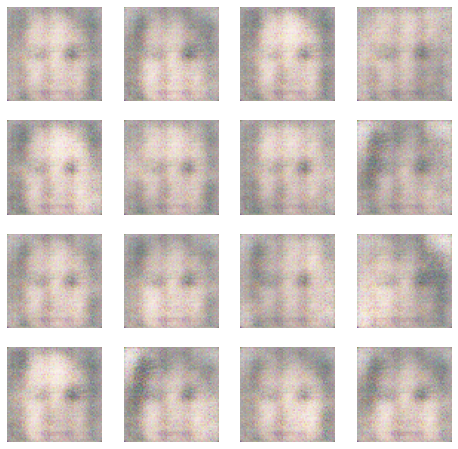

2024-05-14 21:12:12 | Epoch [2/20] | Batch 0/509 | d_loss: 1.3866 | g_loss: 0.6841
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:12:20 | Epoch [2/20] | Batch 50/509 | d_loss: 1.3899 | g_loss: 0.6854
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:12:28 | Epoch [2/20] | Batch 100/509 | d_loss: 1.3866 | g_loss: 0.6910
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:12:35 | Epoch [2/20] | Batch 150/509 | d_loss: 1.3879 | g_loss: 0.6865
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:12:43 | Epoch [2/20] | Batch 200/509 | d_loss: 1.3861 | g_loss: 0.6930
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:12:51 | Epoch [2/20] | B

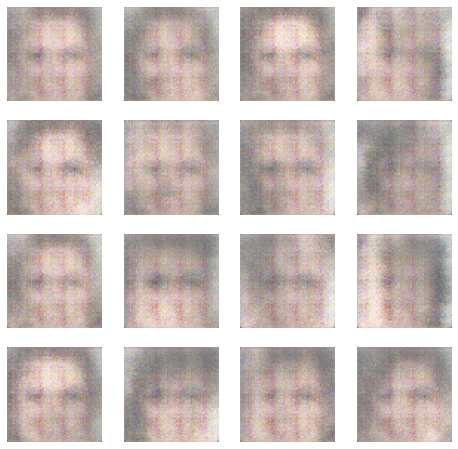

2024-05-14 21:13:34 | Epoch [3/20] | Batch 0/509 | d_loss: 1.3871 | g_loss: 0.6828
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:13:42 | Epoch [3/20] | Batch 50/509 | d_loss: 1.3874 | g_loss: 0.6921
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:13:50 | Epoch [3/20] | Batch 100/509 | d_loss: 1.3876 | g_loss: 0.6905
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:13:57 | Epoch [3/20] | Batch 150/509 | d_loss: 1.3867 | g_loss: 0.6945
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:14:05 | Epoch [3/20] | Batch 200/509 | d_loss: 1.3880 | g_loss: 0.6989
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:14:13 | Epoch [3/20] | B

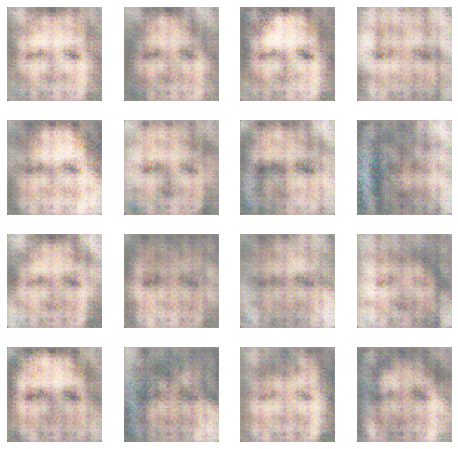

2024-05-14 21:14:57 | Epoch [4/20] | Batch 0/509 | d_loss: 1.3870 | g_loss: 0.6954
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:15:04 | Epoch [4/20] | Batch 50/509 | d_loss: 1.3880 | g_loss: 0.6954
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:15:12 | Epoch [4/20] | Batch 100/509 | d_loss: 1.3868 | g_loss: 0.6969
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:15:20 | Epoch [4/20] | Batch 150/509 | d_loss: 1.3866 | g_loss: 0.6958
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:15:27 | Epoch [4/20] | Batch 200/509 | d_loss: 1.3878 | g_loss: 0.6968
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:15:35 | Epoch [4/20] | B

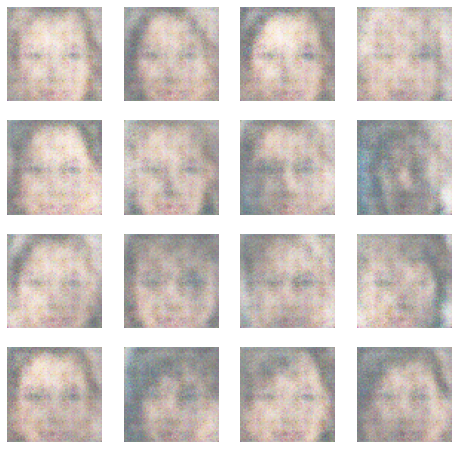

2024-05-14 21:16:18 | Epoch [5/20] | Batch 0/509 | d_loss: 1.3865 | g_loss: 0.6936
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:16:25 | Epoch [5/20] | Batch 50/509 | d_loss: 1.3870 | g_loss: 0.6958
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:16:33 | Epoch [5/20] | Batch 100/509 | d_loss: 1.3868 | g_loss: 0.6939
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:16:41 | Epoch [5/20] | Batch 150/509 | d_loss: 1.3865 | g_loss: 0.6941
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:16:49 | Epoch [5/20] | Batch 200/509 | d_loss: 1.3873 | g_loss: 0.6914
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:16:56 | Epoch [5/20] | B

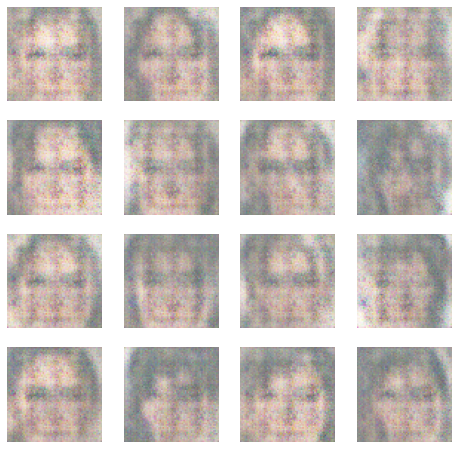

2024-05-14 21:17:39 | Epoch [6/20] | Batch 0/509 | d_loss: 1.3873 | g_loss: 0.6942
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:17:47 | Epoch [6/20] | Batch 50/509 | d_loss: 1.3861 | g_loss: 0.6923
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:17:55 | Epoch [6/20] | Batch 100/509 | d_loss: 1.3868 | g_loss: 0.6938
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:18:02 | Epoch [6/20] | Batch 150/509 | d_loss: 1.3868 | g_loss: 0.6923
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:18:10 | Epoch [6/20] | Batch 200/509 | d_loss: 1.3866 | g_loss: 0.6918
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:18:18 | Epoch [6/20] | B

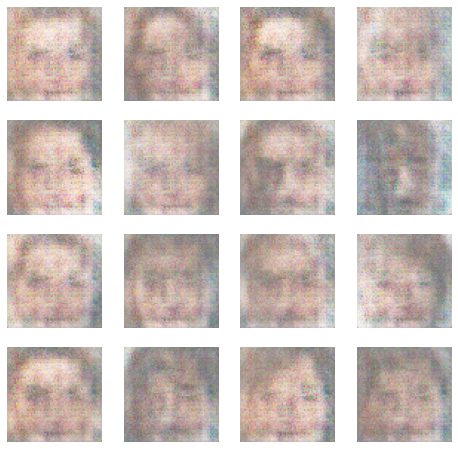

2024-05-14 21:19:02 | Epoch [7/20] | Batch 0/509 | d_loss: 1.3865 | g_loss: 0.6940
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:19:10 | Epoch [7/20] | Batch 50/509 | d_loss: 1.3869 | g_loss: 0.6930
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:19:18 | Epoch [7/20] | Batch 100/509 | d_loss: 1.3864 | g_loss: 0.6920
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:19:25 | Epoch [7/20] | Batch 150/509 | d_loss: 1.3866 | g_loss: 0.6925
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:19:33 | Epoch [7/20] | Batch 200/509 | d_loss: 1.3870 | g_loss: 0.6949
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:19:41 | Epoch [7/20] | B

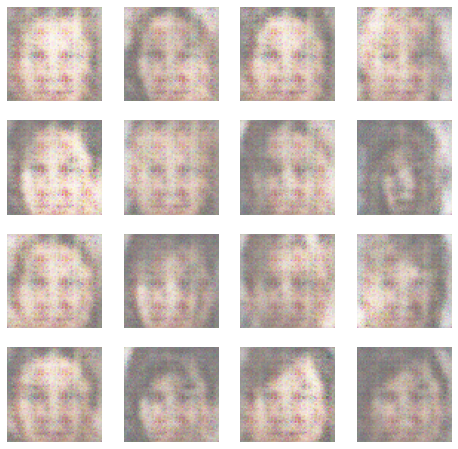

2024-05-14 21:20:24 | Epoch [8/20] | Batch 0/509 | d_loss: 1.3866 | g_loss: 0.6890
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:20:32 | Epoch [8/20] | Batch 50/509 | d_loss: 1.3867 | g_loss: 0.6925
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:20:40 | Epoch [8/20] | Batch 100/509 | d_loss: 1.3867 | g_loss: 0.6934
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:20:47 | Epoch [8/20] | Batch 150/509 | d_loss: 1.3866 | g_loss: 0.6937
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:20:55 | Epoch [8/20] | Batch 200/509 | d_loss: 1.3865 | g_loss: 0.6939
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:21:03 | Epoch [8/20] | B

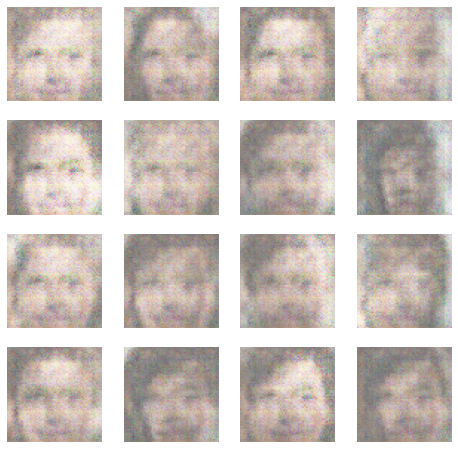

2024-05-14 21:21:48 | Epoch [9/20] | Batch 0/509 | d_loss: 1.3867 | g_loss: 0.6934
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:21:55 | Epoch [9/20] | Batch 50/509 | d_loss: 1.3865 | g_loss: 0.6937
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:22:03 | Epoch [9/20] | Batch 100/509 | d_loss: 1.3864 | g_loss: 0.6930
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:22:10 | Epoch [9/20] | Batch 150/509 | d_loss: 1.3865 | g_loss: 0.6924
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:22:18 | Epoch [9/20] | Batch 200/509 | d_loss: 1.3866 | g_loss: 0.6949
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:22:26 | Epoch [9/20] | B

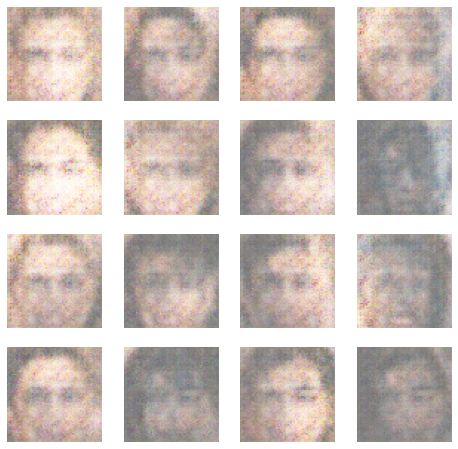

2024-05-14 21:23:10 | Epoch [10/20] | Batch 0/509 | d_loss: 1.3864 | g_loss: 0.6926
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:23:17 | Epoch [10/20] | Batch 50/509 | d_loss: 1.3868 | g_loss: 0.6936
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:23:25 | Epoch [10/20] | Batch 100/509 | d_loss: 1.3865 | g_loss: 0.6930
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:23:33 | Epoch [10/20] | Batch 150/509 | d_loss: 1.3865 | g_loss: 0.6915
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:23:40 | Epoch [10/20] | Batch 200/509 | d_loss: 1.3867 | g_loss: 0.6936
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:23:48 | Epoch [10/2

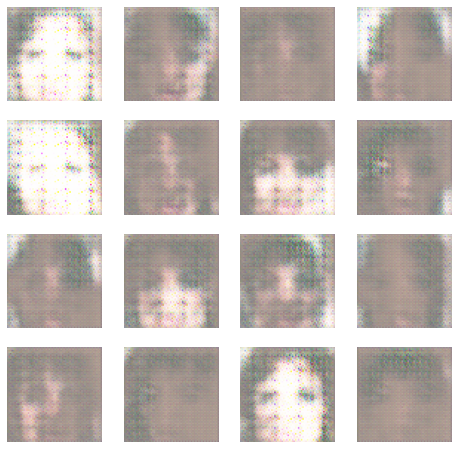

2024-05-14 21:24:32 | Epoch [11/20] | Batch 0/509 | d_loss: 1.3860 | g_loss: 0.6995
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:24:40 | Epoch [11/20] | Batch 50/509 | d_loss: 1.3855 | g_loss: 0.7050
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:24:47 | Epoch [11/20] | Batch 100/509 | d_loss: 1.3847 | g_loss: 0.7061
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:24:55 | Epoch [11/20] | Batch 150/509 | d_loss: 1.3862 | g_loss: 0.6427
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:25:03 | Epoch [11/20] | Batch 200/509 | d_loss: 1.3827 | g_loss: 0.7514
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:25:11 | Epoch [11/2

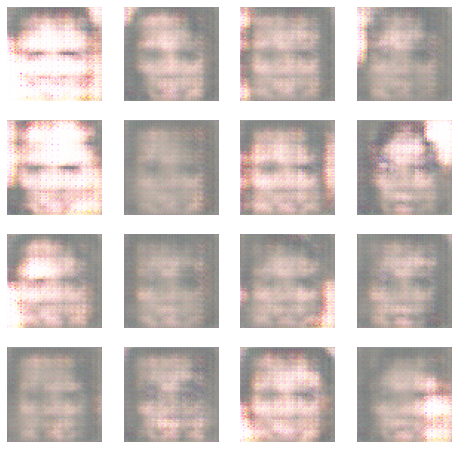

2024-05-14 21:25:53 | Epoch [12/20] | Batch 0/509 | d_loss: 1.3882 | g_loss: 0.7313
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:26:01 | Epoch [12/20] | Batch 50/509 | d_loss: 1.3836 | g_loss: 0.7133
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:26:08 | Epoch [12/20] | Batch 100/509 | d_loss: 1.3824 | g_loss: 0.7148
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:26:16 | Epoch [12/20] | Batch 150/509 | d_loss: 1.3904 | g_loss: 0.7178
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:26:23 | Epoch [12/20] | Batch 200/509 | d_loss: 1.3907 | g_loss: 0.7031
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:26:31 | Epoch [12/2

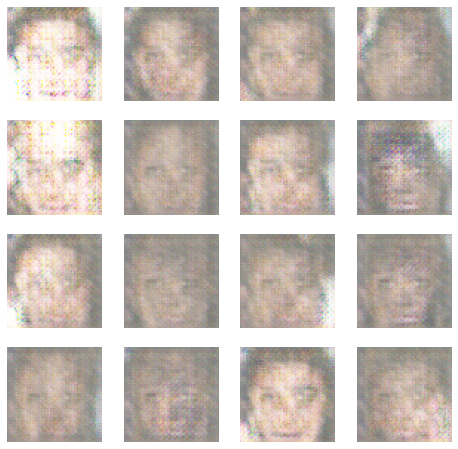

2024-05-14 21:27:15 | Epoch [13/20] | Batch 0/509 | d_loss: 1.3860 | g_loss: 0.6914
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:27:23 | Epoch [13/20] | Batch 50/509 | d_loss: 1.3965 | g_loss: 0.6862
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:27:31 | Epoch [13/20] | Batch 100/509 | d_loss: 1.3881 | g_loss: 0.6925
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:27:38 | Epoch [13/20] | Batch 150/509 | d_loss: 1.3869 | g_loss: 0.6913
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:27:46 | Epoch [13/20] | Batch 200/509 | d_loss: 1.3886 | g_loss: 0.6872
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:27:54 | Epoch [13/2

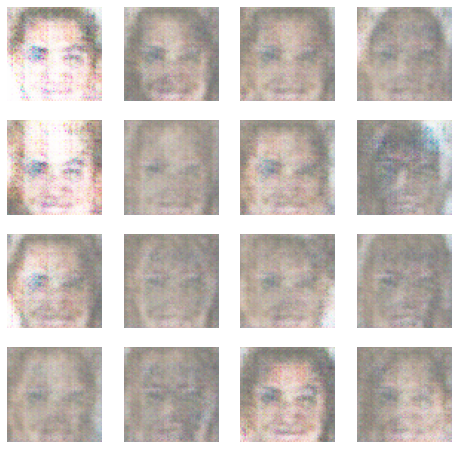

2024-05-14 21:28:38 | Epoch [14/20] | Batch 0/509 | d_loss: 1.3863 | g_loss: 0.6898
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:28:45 | Epoch [14/20] | Batch 50/509 | d_loss: 1.3869 | g_loss: 0.6892
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:28:53 | Epoch [14/20] | Batch 100/509 | d_loss: 1.3876 | g_loss: 0.6950
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:29:01 | Epoch [14/20] | Batch 150/509 | d_loss: 1.3868 | g_loss: 0.6905
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:29:08 | Epoch [14/20] | Batch 200/509 | d_loss: 1.3879 | g_loss: 0.6904
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:29:16 | Epoch [14/2

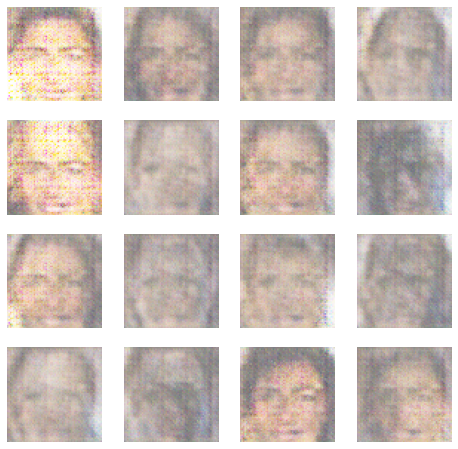

2024-05-14 21:30:00 | Epoch [15/20] | Batch 0/509 | d_loss: 1.3857 | g_loss: 0.6994
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:30:07 | Epoch [15/20] | Batch 50/509 | d_loss: 1.3880 | g_loss: 0.7020
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:30:15 | Epoch [15/20] | Batch 100/509 | d_loss: 1.3890 | g_loss: 0.6933
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:30:23 | Epoch [15/20] | Batch 150/509 | d_loss: 1.3876 | g_loss: 0.6950
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:30:31 | Epoch [15/20] | Batch 200/509 | d_loss: 1.3871 | g_loss: 0.6894
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:30:38 | Epoch [15/2

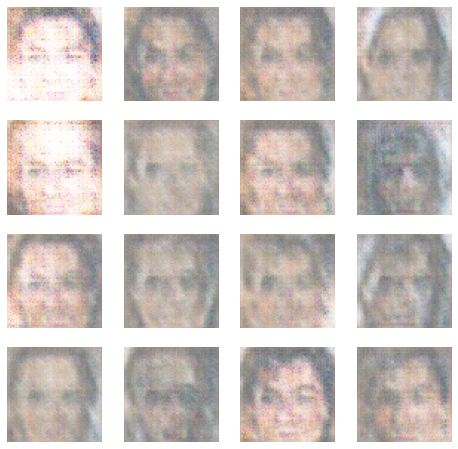

2024-05-14 21:31:22 | Epoch [16/20] | Batch 0/509 | d_loss: 1.3882 | g_loss: 0.6972
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:31:29 | Epoch [16/20] | Batch 50/509 | d_loss: 1.3870 | g_loss: 0.6936
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:31:37 | Epoch [16/20] | Batch 100/509 | d_loss: 1.3863 | g_loss: 0.6823
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:31:45 | Epoch [16/20] | Batch 150/509 | d_loss: 1.3876 | g_loss: 0.6938
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:31:52 | Epoch [16/20] | Batch 200/509 | d_loss: 1.3873 | g_loss: 0.6977
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:32:00 | Epoch [16/2

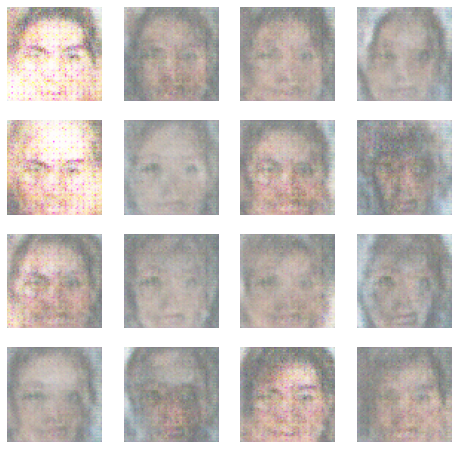

2024-05-14 21:32:44 | Epoch [17/20] | Batch 0/509 | d_loss: 1.3870 | g_loss: 0.6924
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:32:51 | Epoch [17/20] | Batch 50/509 | d_loss: 1.3876 | g_loss: 0.6967
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:32:59 | Epoch [17/20] | Batch 100/509 | d_loss: 1.3879 | g_loss: 0.6946
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:33:07 | Epoch [17/20] | Batch 150/509 | d_loss: 1.3854 | g_loss: 0.6867
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:33:14 | Epoch [17/20] | Batch 200/509 | d_loss: 1.3865 | g_loss: 0.6903
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:33:22 | Epoch [17/2

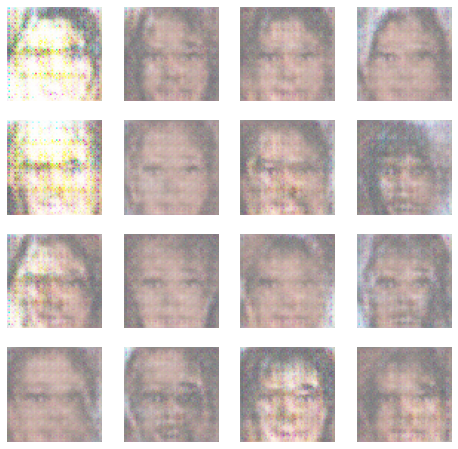

2024-05-14 21:34:06 | Epoch [18/20] | Batch 0/509 | d_loss: 1.3866 | g_loss: 0.6958
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:34:14 | Epoch [18/20] | Batch 50/509 | d_loss: 1.3872 | g_loss: 0.6915
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:34:22 | Epoch [18/20] | Batch 100/509 | d_loss: 1.3878 | g_loss: 0.6855
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:34:29 | Epoch [18/20] | Batch 150/509 | d_loss: 1.3868 | g_loss: 0.6912
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:34:37 | Epoch [18/20] | Batch 200/509 | d_loss: 1.3855 | g_loss: 0.6938
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:34:45 | Epoch [18/2

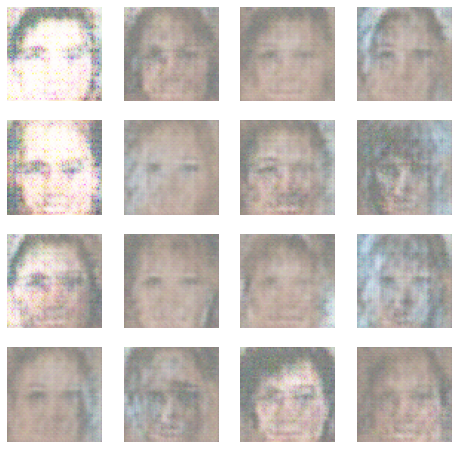

2024-05-14 21:35:29 | Epoch [19/20] | Batch 0/509 | d_loss: 1.3870 | g_loss: 0.6935
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:35:36 | Epoch [19/20] | Batch 50/509 | d_loss: 1.3870 | g_loss: 0.6911
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:35:44 | Epoch [19/20] | Batch 100/509 | d_loss: 1.3868 | g_loss: 0.6911
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:35:51 | Epoch [19/20] | Batch 150/509 | d_loss: 1.3883 | g_loss: 0.6917
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:35:59 | Epoch [19/20] | Batch 200/509 | d_loss: 1.3865 | g_loss: 0.6923
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:36:07 | Epoch [19/2

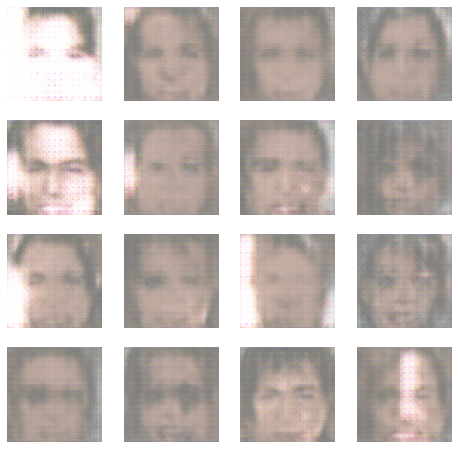

2024-05-14 21:36:50 | Epoch [20/20] | Batch 0/509 | d_loss: 1.3560 | g_loss: 0.6836
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:36:58 | Epoch [20/20] | Batch 50/509 | d_loss: 1.3755 | g_loss: 0.6294
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:37:05 | Epoch [20/20] | Batch 100/509 | d_loss: 1.3836 | g_loss: 0.7308
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:37:13 | Epoch [20/20] | Batch 150/509 | d_loss: 1.3259 | g_loss: 0.7555
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:37:20 | Epoch [20/20] | Batch 200/509 | d_loss: 1.3399 | g_loss: 0.7829
Real Images Tensor Shape: torch.Size([64, 3, 64, 64])
Fake Images Tensor Shape: torch.Size([64, 3, 64, 64])
2024-05-14 21:37:28 | Epoch [20/2

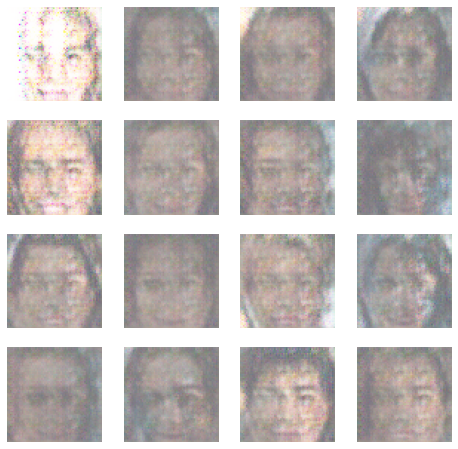

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from datetime import datetime
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from PIL import Image
import os
import numpy as np


# Loss Function
criterion = nn.BCELoss()

fixed_latent_vector = torch.randn(16, latent_dim, 1, 1).to(device)

losses = []
for epoch in range(n_epochs):
    for batch_i, real_images in enumerate(dataloader):
        real_images = real_images.to(device)
        batch_size = real_images.size(0)
        
        # Add noise to the input image
        noise = torch.randn_like(real_images) * 0.1
        real_images += noise

        # Training Discriminator
        d_loss = discriminator_step(batch_size, latent_dim, real_images, generator, discriminator, d_optimizer, criterion, label_smoothing=True, device=device)
        
        # Train the generator more often than the discriminator
        for _ in range(2):
            g_loss = generator_step(batch_size, latent_dim, generator, discriminator, g_optimizer, criterion, device=device)
      
        if batch_i % print_every == 0:
            losses.append((d_loss['loss'], g_loss['loss']))
            time = str(datetime.now()).split('.')[0]
            print(f'{time} | Epoch [{epoch+1}/{n_epochs}] | Batch {batch_i}/{len(dataloader)} | d_loss: {d_loss["loss"]:.4f} | g_loss: {g_loss["loss"]:.4f}')
            print(f'Real Images Tensor Shape: {real_images.shape}')
            print(f'Fake Images Tensor Shape: {generator(torch.randn(batch_size, latent_dim, 1, 1).to(device)).shape}')

    # Display images during training
    generator.eval()
    with torch.no_grad():
        generated_images = generator(fixed_latent_vector).cpu()
    fig = plt.figure(figsize=(8, 8))
    for i in range(16):
        ax = fig.add_subplot(4, 4, i+1)
        img = np.transpose(generated_images[i].numpy(), (1, 2, 0))
        img = ((img + 1) / 2 * 255).astype(np.uint8)
        ax.imshow(img)
        ax.axis('off')
    plt.show()
    generator.train()


### Training losses

Plot the training losses for the generator and discriminator.

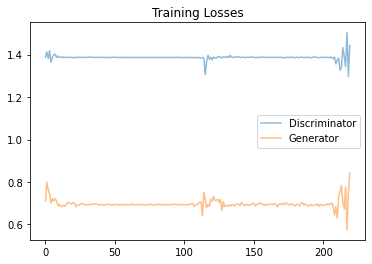

In [26]:
"""
DO NOT MODIFY ANYTHING IN THIS CELL
"""
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

### Question: What do you notice about your generated samples and how might you improve this model?
When you answer this question, consider the following factors:
* The dataset is biased; it is made of "celebrity" faces that are mostly white
* Model size; larger models have the opportunity to learn more features in a data feature space
* Optimization strategy; optimizers and number of epochs affect your final result
* Loss functions

**Answer:** (Write your answer in this cell)

#### Observations on Generated Samples:
1. **Dataset Bias**:
   - The dataset comprises "celebrity" faces that are predominantly white. This introduces a significant bias in the training data, limiting the diversity of generated faces. As a result, the model might not perform well on generating faces of other ethnicities, leading to a lack of representation and fairness in the outputs.

2. **Model Size**:
   - Larger models have the capacity to learn more complex features and representations from the data. If the current model is small, it might not capture all the nuances required to generate high-quality and diverse images. Increasing the model size (e.g., adding more layers or increasing the number of units in each layer) could help in learning richer features.

3. **Optimization Strategy**:
   - The choice of optimizer and the number of training epochs play a crucial role in the final model performance. Using optimizers like Adam or RMSprop with appropriate learning rates can lead to better convergence. Additionally, training for more epochs can allow the model to learn better representations, but care must be taken to avoid overfitting.

4. **Loss Functions**:
   - The choice of loss function impacts the training dynamics of GANs. Standard GAN loss functions can sometimes lead to issues like mode collapse. Exploring alternative loss functions such as Wasserstein loss or hinge loss might improve the stability and quality of the generated samples.

#### Suggestions for Model Improvement:
1. **Addressing Dataset Bias**:
   - Introduce more diversity in the training dataset. This can involve adding more images of people from various ethnic backgrounds to ensure a balanced and fair representation. This will help the model to learn a wider range of features and generate more diverse faces.

2. **Increasing Model Complexity**:
   - Experiment with deeper and more complex architectures. Adding more convolutional layers or increasing the number of filters in each layer can enhance the model's ability to learn intricate features. However, this should be balanced with the risk of overfitting, especially if the dataset size remains the same.

3. **Optimization Enhancements**:
   - Tune the hyperparameters of the optimizer, such as learning rate and beta values for Adam. Consider using learning rate schedulers to adjust the learning rate during training dynamically. This can help in better convergence and avoid getting stuck in local minima.

4. **Exploring Advanced Loss Functions**:
   - Implement and experiment with advanced loss functions like the Wasserstein loss, which provides smoother gradients and can lead to more stable training. The Wasserstein GAN (WGAN) approach often results in better quality samples compared to the vanilla GAN loss.

5. **Data Augmentation**:
   - Apply data augmentation techniques to artificially increase the diversity of the training data. Techniques such as random cropping, rotation, and flipping can help the model to generalize better.

6. **Regularization Techniques**:
   - Incorporate regularization methods such as dropout or spectral normalization to prevent overfitting and improve generalization. These techniques can help in stabilizing the training process and lead to better-quality generated images.

By addressing these aspects, you can improve the quality and diversity of the generated samples, leading to a more robust and fair model.


### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb".  

Submit the notebook using the ***SUBMIT*** button in the bottom right corner of the Project Workspace.